In [1]:
import sys
sys.path.append("../code")

#for p in sys.path:
#    print(p)

In [2]:
import base as bs
import utils as ut
import snr as snr
import viz as viz

import json
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Importing waveform strain

In [24]:
import h5py
import os
import lal

Msun_sec = 4.9e-6
Msun_m = 1476.62
MPc_m = 3.0856776e+22

Mtot = 2.7
D_l_MPc = 100
theta, phi = [0, 0]
Y_22 = lal.SpinWeightedSphericalHarmonic(theta, phi,-2,2,2) 



filename = '../files/BAM_0065/R06/data.h5'


with h5py.File(filename, "r") as f:
    #print(f['rh_22'].keys())
    obj = f['rh_22']['Rh_l2_m2_r00900.txt']
    data = np.array(obj).T

# U/M * M
t = data[0]* Mtot * Msun_sec
# r*h_22* s_weighted_sph-harm(-2_Y_22) * (distance_in_meters)/(totalmass_in_meters)
strain = data[-3]*np.exp(1j*data[-2])* Y_22 * ((Msun_m*Mtot)/(D_l_MPc*MPc_m))

wf0 = bs.time_domain(t-t[np.abs(strain).argmax()], strain.real)

# windowing only the postmerger waveform
wf_p0 = wf0.cut([-2e-3, 60e-3], alpha=0.2) 
wf_p1 = wf0.cut([-5e-3, 60e-3], alpha=0.1)

# Importing detector design curves(amplitude spectral density)

In [25]:
path_sc = '../files/design_curves/'
sc0 = ut.ASD('et_d', path_sc)

# Time domain

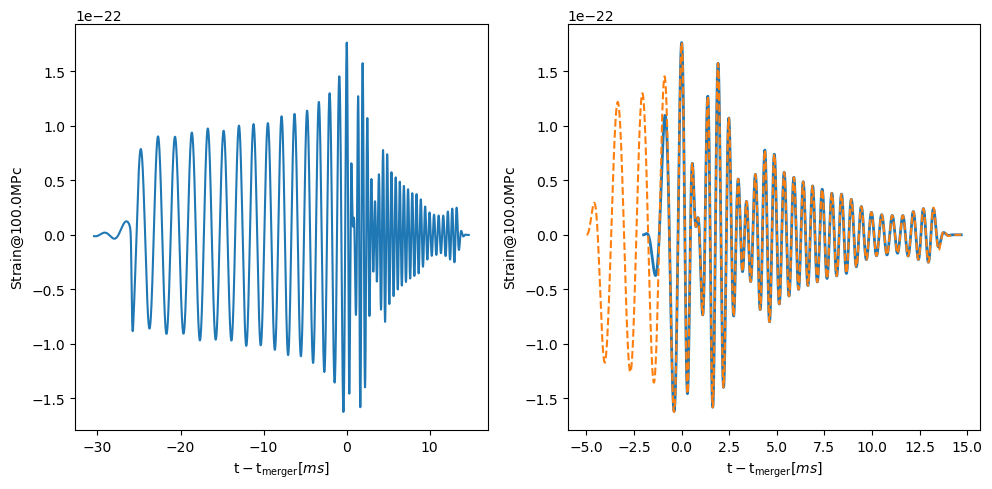

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(wf0.td*1e3, wf0.data.real)
plt.ylabel(r'$\mathrm{Strain@100.0MPc}$');
plt.xlabel(r'$\mathrm{t-t_{merger}}[ms]$');

plt.subplot(1,2,2)
plt.plot(wf_p0.td*1e3, wf_p0.data.real, linewidth=2)
plt.plot(wf_p1.td*1e3, wf_p1.data.real, linestyle='dashed')

plt.ylabel(r'$\mathrm{Strain@100.0MPc}$');
plt.xlabel(r'$\mathrm{t-t_{merger}}[ms]$');

plt.tight_layout()

# Frequency domain

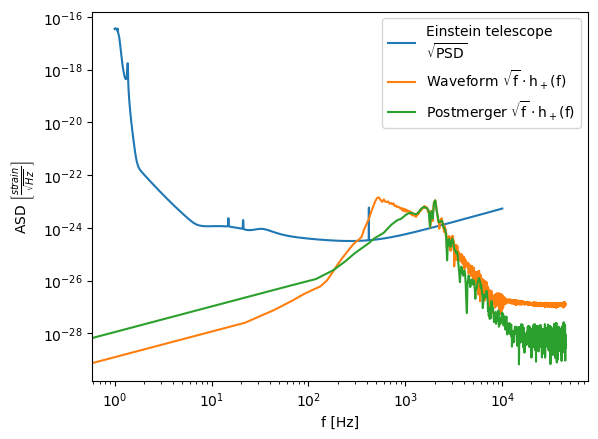

In [48]:
wf0_fd = wf0.to_fd()
wf_p0_fd = wf_p0.to_fd()

plt.loglog(sc0.fd, sc0.ASD, label='Einstein telescope \n'+r'$\mathrm{\sqrt{PSD}}$')
plt.loglog(wf0_fd.fd, wf0_fd.fd**0.5 *np.abs(wf0_fd.data), label='Waveform '+r'$\mathrm{\sqrt{f}\cdot h_+(f)}$')
plt.loglog(wf_p0_fd.fd, wf_p0_fd.fd**0.5 * np.abs(wf_p0_fd.data), label='Postmerger '+r'$\mathrm{\sqrt{f}\cdot h_+(f)}$')

plt.ylabel(r'ASD $\left[  \frac{strain}{\sqrt{Hz}} \right]$');
plt.xlabel('f [Hz]');

plt.legend()

# Finite monochromatic waves

In [51]:
f0,f1,f2 = 1000, 2200, 3000
templ0 = ut.monochr_templ(f0, wf_p0.dur, wf_p0.dt, t_0=wf_p0.t_0,
                          amp=wf_p0.data.max(),phase=0,
                         alpha=0.1)
templ1 = ut.monochr_templ(f1, wf_p0.dur, wf_p0.dt, t_0=wf_p0.t_0,
                          amp=wf_p0.data.max(),phase=0,
                         alpha=0.1)
templ2 = ut.monochr_templ(f2, wf_p0.dur, wf_p0.dt, t_0=wf_p0.t_0,
                          amp=wf_p0.data.max(),phase=0,
                         alpha=0.1)

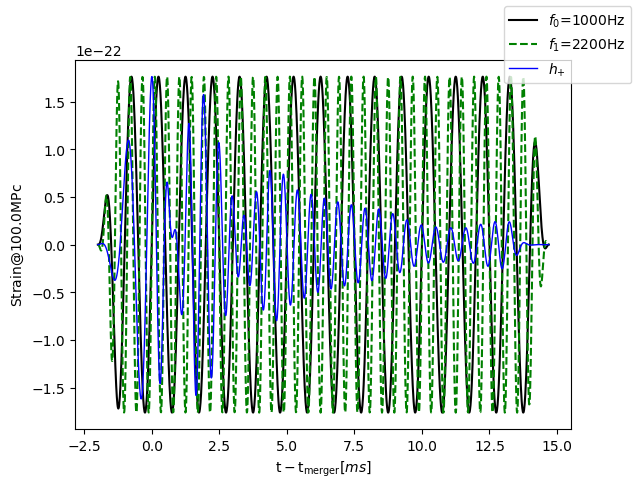

In [56]:
fig=plt.figure()
plt.ylabel(r'$\mathrm{Strain@100.0MPc}$');
plt.xlabel(r'$\mathrm{t-t_{merger}}[ms]$');


plt.plot(templ0.td*1e3, templ0.data, linestyle='-', color='black', label=r'$f_{0}$'+f'={f0}Hz')
plt.plot(templ1.td*1e3, templ1.data, linestyle='--', color='green', label=r'$f_{1}$'+f'={f1}Hz')
plt.plot(wf_p0.td*1e3, wf_p0.data.real, linewidth=1,color='blue',label=r'${h_{+}}$')

fig.legend(loc='upper right', fontsize=10)

## Example: Signal-to-noise ratio as a function of timeshift

$$ \rho(\tau)=\langle h, q\rangle(\tau) = 4 \cdot | \int_{0}^{\infty} \frac{h^*(f)\cdot q(f) e^{-i2\pi f \tau} }{S_n(f)} df |$$

 - Template -> q: finite monochromatic template model. It has 2 free parameters(Frequency and duration)

 - Signal -> h: wf_p0
 - PSD -> S_n: Einstein telescope

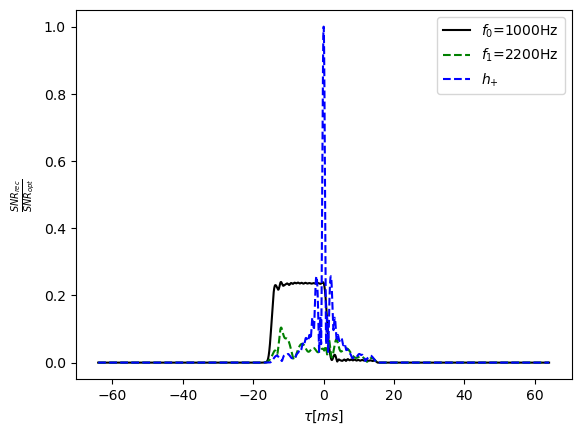

In [53]:
Mf0, Mf1, Mf2 = [snr.matched_filtering(wf_p0, templ0 , sc0),
                snr.matched_filtering(wf_p0, templ1 , sc0),
                snr.matched_filtering(wf_p0, wf_p0 , sc0)]

sopt = Mf0.optimal_SNR(N=5000, cut_sc=None).data.max()


match0 = Mf0.recovered_SNR3(N=5000)
match1 = Mf1.recovered_SNR3(N=5000)
match2 = Mf2.recovered_SNR3(N=5000)

plt.figure() 
plt.ylabel(r'$\frac{SNR_{rec}}{SNR_{opt}}$')
plt.xlabel(r'$\tau[ms]$')
plt.plot(match0.td*1e3,np.abs(match0.data)/sopt, color='black', label=r'$f_{0}$'+f'={f0}Hz')
plt.plot(match0.td*1e3,np.abs(match1.data)/sopt, color='green',linestyle='--', label=r'$f_{1}$'+f'={f1}Hz')
plt.plot(match0.td*1e3,np.abs(match2.data)/sopt, color='blue',linestyle='--', label=r'$h_{+}$')

plt.legend()

# Generalized Matched filter function

The function genrlzd_SNR1 contained in the snr module, is a vectorized function that can take a set of templates with parameters (a1,..., an), find the maximum SNR, and return a mesh

# Example: 1D parameter space

- fix duration and vary the frequency

In [57]:
d= [wf_p0.dur]
f= np.linspace(50, 5000, 500)
a = 0.1
templ = lambda f,d,dt,t_0=wf_p0.t_0,amp=1:ut.monochr_templ(f, d, dt, 
                                                   t_0,amp, phase=0,
                                                    alpha=a)

tau1 = 0

f_mesh0, d_mesh0 = np.meshgrid(f,d)

one_pT = snr.genrlzd_SNR1(wf_p0,templ,sc0,
                           f_mesh0, d_mesh0, N=5000, cut_sc=None,
                           taufix=tau1, phase_opt=True, cut_pfind=None)

one_pF = snr.genrlzd_SNR1(wf_p0,templ,sc0,
                           f_mesh0, d_mesh0, N=5000, cut_sc=None,
                           taufix=tau1, phase_opt=False, cut_pfind=None)

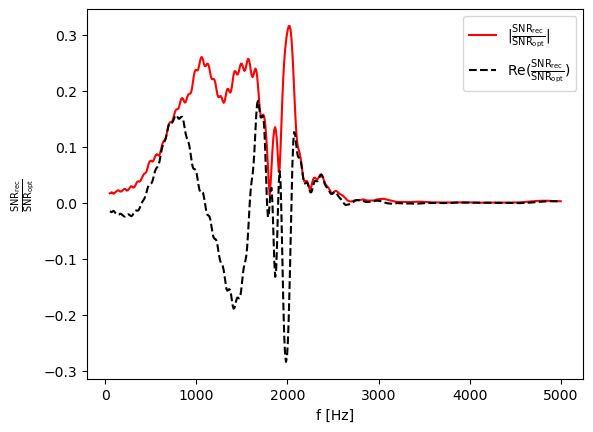

In [58]:
plt.figure()
plt.ylabel(r'$\mathrm{\frac{SNR_{rec}}{SNR_{opt}}}$')
plt.xlabel(r'f [Hz]')
plt.plot(f,one_pT.flatten()/sopt, color='red', label=r'$\mathrm{|\frac{SNR_{rec}}{SNR_{opt}}|}$')
plt.plot(f,one_pF.flatten()/sopt, linestyle='--', color='black',label=r'$\mathrm{Re(\frac{SNR_{rec}}{SNR_{opt}})}$')
plt.legend(loc='upper right')
plt.show()

# Example: 1D parameter space

- fix duration and vary the frequency

In [59]:
d= np.linspace(0.1*wf_p0.dur, 1.5*wf_p0.dur, 500)
f= [2000]
tau1 = 0

f_mesh0, d_mesh0 = np.meshgrid(f,d)

one_pT = snr.genrlzd_SNR1(wf_p0,templ,sc0,
                           f_mesh0, d_mesh0, N=5000, cut_sc=None,
                           taufix=tau1, phase_opt=True, cut_pfind=None)

one_pF = snr.genrlzd_SNR1(wf_p0,templ,sc0,
                           f_mesh0, d_mesh0, N=5000, cut_sc=None,
                           taufix=tau1, phase_opt=False, cut_pfind=None)

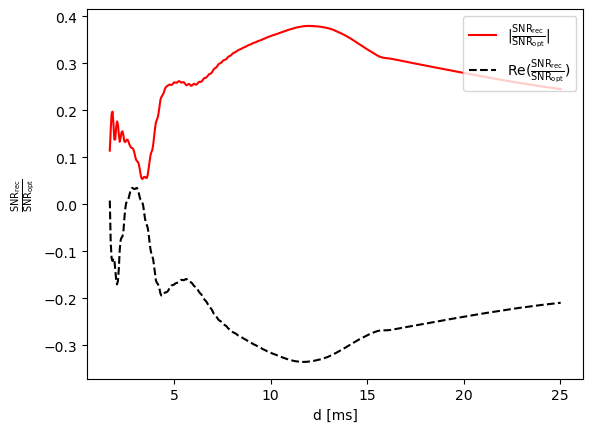

In [60]:
plt.figure()
plt.ylabel(r'$\mathrm{\frac{SNR_{rec}}{SNR_{opt}}}$')
plt.xlabel(r'd [ms]')
plt.plot(d*1e3,one_pT.flatten()/sopt, color='red', label=r'$\mathrm{|\frac{SNR_{rec}}{SNR_{opt}}|}$')
plt.plot(d*1e3,one_pF.flatten()/sopt, linestyle='--', color='black',label=r'$\mathrm{Re(\frac{SNR_{rec}}{SNR_{opt}})}$')
plt.legend(loc='upper right')
plt.show()